# PixArt-α: Fast Training of Diffusion Transformer for Photorealistic Text-to-Image Synthesis with OpenVINO

[This paper](https://arxiv.org/abs/2310.00426) introduces [PIXART-α](https://github.com/PixArt-alpha/PixArt-alpha), a Transformer-based T2I diffusion model whose image generation quality is competitive with state-of-the-art image generators, reaching near-commercial application standards. Additionally, it supports high-resolution image synthesis up to 1024px resolution with low training cost. To achieve this goal, three core designs are proposed: 
1. Training strategy decomposition: We devise three distinct training steps that separately optimize pixel dependency, text-image alignment, and image aesthetic quality; 
2. Efficient T2I Transformer: We incorporate cross-attention modules into Diffusion Transformer (DiT) to inject text conditions and streamline the computation-intensive class-condition branch; 
3. High-informative data: We emphasize the significance of concept density in text-image pairs and leverage a large Vision-Language model to auto-label dense pseudo-captions to assist text-image alignment learning. 

![](https://huggingface.co/PixArt-alpha/PixArt-XL-2-1024-MS/resolve/main/asset/images/teaser.png)


#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Load the original model](#Load-the-original-model)
- [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR)
  - [Convert text encoder](#Convert-text-encoder)
  - [Convert transformer](#Convert-transformer)
  - [Convert VAE decoder](#Convert-VAE-decoder)
- [Compiling models](#Compiling-models)
- [Building the pipeline](#Building-the-pipeline)
- [Interactive inference](#Interactive-inference)
### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/pixart/pixart.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "diffusers>=0.14.0" sentencepiece "datasets>=2.14.6" "transformers>=4.25.1" "gradio>=4.19" "torch>=2.1" Pillow opencv-python --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -Uq "openvino>=2024.3.0"

## Load and run the original pipeline
[back to top ⬆️](#Table-of-contents:)

We use [PixArt-LCM-XL-2-1024-MS](https://huggingface.co/PixArt-alpha/PixArt-LCM-XL-2-1024-MS) that uses LCMs. [LCMs](https://arxiv.org/abs/2310.04378) is a diffusion distillation method which predict `PF-ODE's` solution directly in latent space, achieving super fast inference with few steps.

In [ ]:
import torch
from diffusers import PixArtAlphaPipeline


pipe = PixArtAlphaPipeline.from_pretrained("PixArt-alpha/PixArt-LCM-XL-2-1024-MS", use_safetensors=True)

prompt = "A small cactus with a happy face in the Sahara desert."
generator = torch.Generator().manual_seed(42)

image = pipe(prompt, guidance_scale=0.0, num_inference_steps=4, generator=generator).images[0]

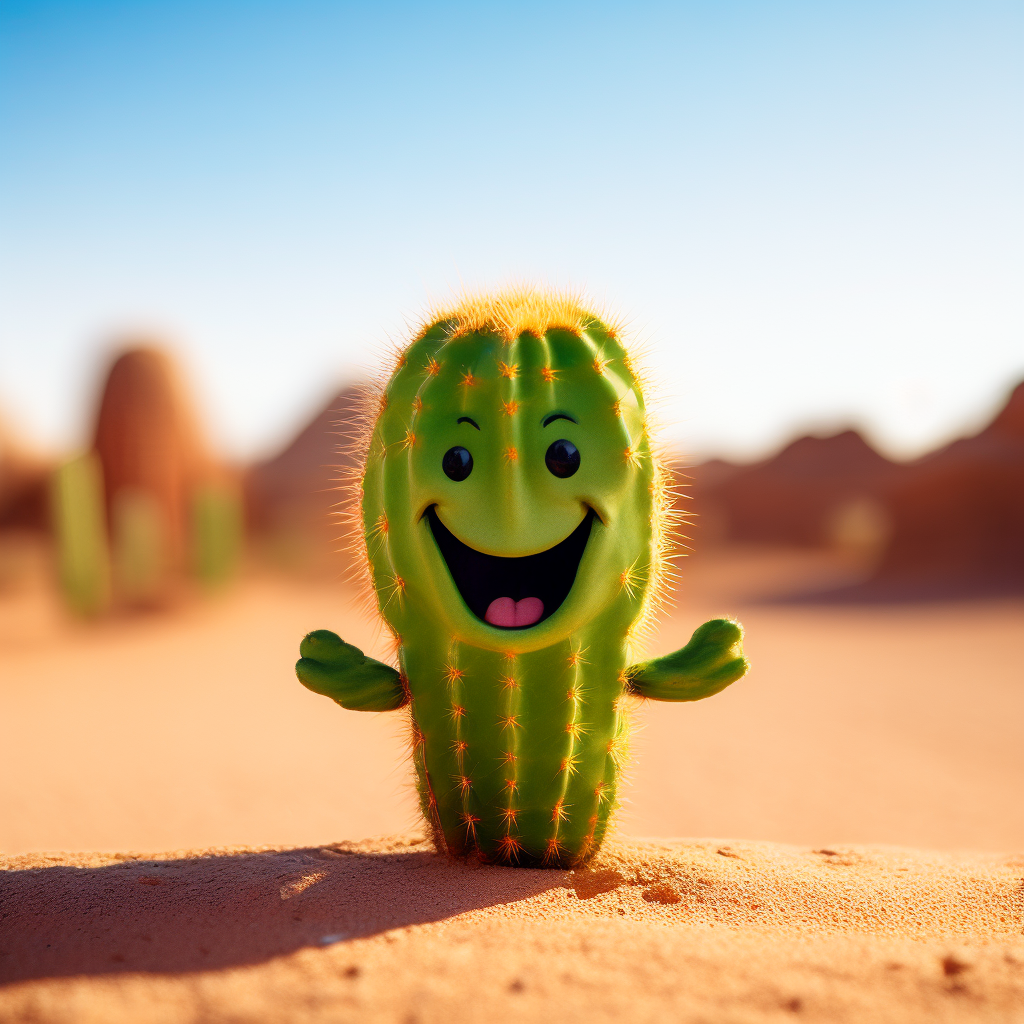

In [3]:
image

## Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

Let's define the conversion function for PyTorch modules. We use `ov.convert_model` function to obtain OpenVINO Intermediate Representation object and `ov.save_model` function to save it as XML file.

In [4]:
from pathlib import Path

import numpy as np
import torch

import openvino as ov


def convert(model: torch.nn.Module, xml_path: str, example_input):
    xml_path = Path(xml_path)
    if not xml_path.exists():
        xml_path.parent.mkdir(parents=True, exist_ok=True)
        model.eval()
        with torch.no_grad():
            converted_model = ov.convert_model(model, example_input=example_input)
        ov.save_model(converted_model, xml_path)

        # cleanup memory
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

PixArt-α consists of pure transformer blocks for latent diffusion: It can directly generate 1024px images from text prompts within a single sampling process.

![](https://huggingface.co/PixArt-alpha/PixArt-XL-2-1024-MS/resolve/main/asset/images/model.png).

During inference it uses text encoder `T5EncoderModel`, transformer `Transformer2DModel` and VAE decoder `AutoencoderKL`. Let's convert the models from the pipeline one by one.

In [5]:
MODEL_DIR = Path("model")

TEXT_ENCODER_PATH = MODEL_DIR / "text_encoder.xml"
TRANSFORMER_OV_PATH = MODEL_DIR / "transformer_ir.xml"
VAE_DECODER_PATH = MODEL_DIR / "vae_decoder.xml"

### Convert text encoder
[back to top ⬆️](#Table-of-contents:)

In [6]:
example_input = {
    "input_ids": torch.zeros(1, 120, dtype=torch.int64),
    "attention_mask": torch.zeros(1, 120, dtype=torch.int64),
}

convert(pipe.text_encoder, TEXT_ENCODER_PATH, example_input)

### Convert transformer
[back to top ⬆️](#Table-of-contents:)

In [7]:
class TransformerWrapper(torch.nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer

    def forward(self, hidden_states=None, timestep=None, encoder_hidden_states=None, encoder_attention_mask=None, resolution=None, aspect_ratio=None):

        return self.transformer.forward(
            hidden_states,
            timestep=timestep,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            added_cond_kwargs={"resolution": resolution, "aspect_ratio": aspect_ratio},
        )


example_input = {
    "hidden_states": torch.rand([2, 4, 128, 128], dtype=torch.float32),
    "timestep": torch.tensor([999, 999]),
    "encoder_hidden_states": torch.rand([2, 120, 4096], dtype=torch.float32),
    "encoder_attention_mask": torch.rand([2, 120], dtype=torch.float32),
    "resolution": torch.tensor([[1024.0, 1024.0], [1024.0, 1024.0]]),
    "aspect_ratio": torch.tensor([[1.0], [1.0]]),
}


w_transformer = TransformerWrapper(pipe.transformer)
convert(w_transformer, TRANSFORMER_OV_PATH, example_input)

### Convert VAE decoder
[back to top ⬆️](#Table-of-contents:)

In [8]:
class VAEDecoderWrapper(torch.nn.Module):

    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, latents):
        return self.vae.decode(latents, return_dict=False)


convert(VAEDecoderWrapper(pipe.vae), VAE_DECODER_PATH, (torch.zeros((1, 4, 128, 128))))

## Compiling models
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

In [9]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

In [10]:
core = ov.Core()

compiled_model = core.compile_model(TRANSFORMER_OV_PATH)
compiled_vae = core.compile_model(VAE_DECODER_PATH)
compiled_text_encoder = core.compile_model(TEXT_ENCODER_PATH)

## Building the pipeline
[back to top ⬆️](#Table-of-contents:)

Let's create callable wrapper classes for compiled models to allow interaction with original pipelines. Note that all of wrapper classes return `torch.Tensor`s instead of `np.array`s.

In [11]:
from collections import namedtuple

EncoderOutput = namedtuple("EncoderOutput", "last_hidden_state")


class TextEncoderWrapper(torch.nn.Module):
    def __init__(self, text_encoder, dtype):
        super().__init__()
        self.text_encoder = text_encoder
        self.dtype = dtype

    def forward(self, input_ids=None, attention_mask=None):
        inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        }
        last_hidden_state = self.text_encoder(inputs)[0]
        return EncoderOutput(torch.from_numpy(last_hidden_state))

In [12]:
class TransformerWrapper(torch.nn.Module):
    def __init__(self, transformer, config):
        super().__init__()
        self.transformer = transformer
        self.config = config

    def forward(
        self,
        hidden_states=None,
        timestep=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        resolution=None,
        aspect_ratio=None,
        added_cond_kwargs=None,
        **kwargs
    ):
        inputs = {
            "hidden_states": hidden_states,
            "timestep": timestep,
            "encoder_hidden_states": encoder_hidden_states,
            "encoder_attention_mask": encoder_attention_mask,
        }
        resolution = added_cond_kwargs["resolution"]
        aspect_ratio = added_cond_kwargs["aspect_ratio"]
        if resolution is not None:
            inputs["resolution"] = resolution
            inputs["aspect_ratio"] = aspect_ratio
        outputs = self.transformer(inputs)[0]

        return [torch.from_numpy(outputs)]

In [13]:
class VAEWrapper(torch.nn.Module):
    def __init__(self, vae, config):
        super().__init__()
        self.vae = vae
        self.config = config

    def decode(self, latents=None, **kwargs):
        inputs = {
            "latents": latents,
        }

        outs = self.vae(inputs)
        outs = namedtuple("VAE", "sample")(torch.from_numpy(outs[0]))

        return outs

And insert wrappers instances in the pipeline:

In [14]:
pipe.__dict__["_internal_dict"]["_execution_device"] = pipe._execution_device  # this is to avoid some problem that can occur in the pipeline

pipe.register_modules(
    text_encoder=TextEncoderWrapper(compiled_text_encoder, pipe.text_encoder.dtype),
    transformer=TransformerWrapper(compiled_model, pipe.transformer.config),
    vae=VAEWrapper(compiled_vae, pipe.vae.config),
)

In [ ]:
generator = torch.Generator().manual_seed(42)

image = pipe(prompt=prompt, guidance_scale=0.0, num_inference_steps=4, generator=generator).images[0]

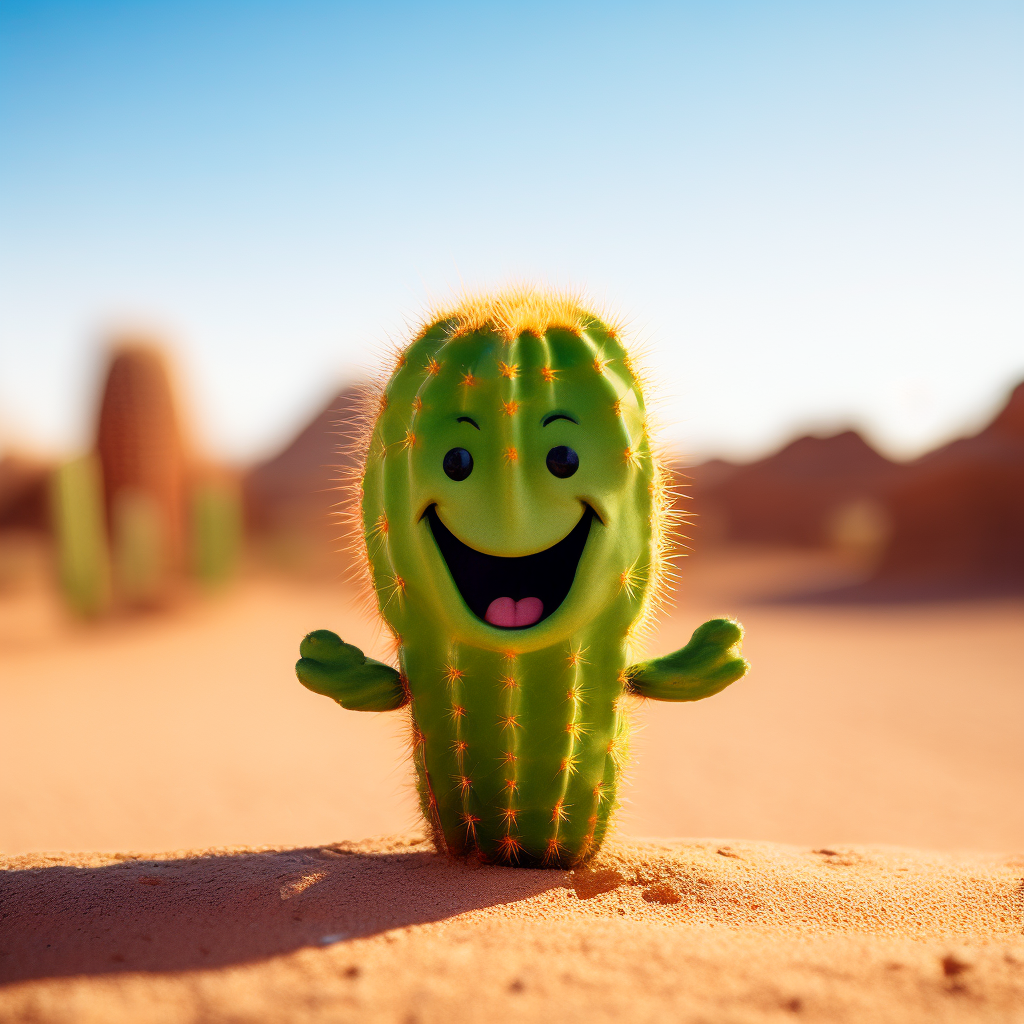

In [16]:
image

## Interactive inference
[back to top ⬆️](#Table-of-contents:)

In [ ]:
def generate(prompt, seed, negative_prompt, num_inference_steps):
    generator = torch.Generator().manual_seed(seed)
    image = pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, generator=generator, guidance_scale=0.0).images[0]
    return image


if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/pixart/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=generate)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

In [ ]:
# please uncomment and run this cell for stopping gradio interface
# demo.close()